In [1]:
import os
import numpy as np 
import shutil
from IPython.display import clear_output

homeDir = "/DockerProjects/walkCAM/tug/temporalCNN_wLabel"
os.chdir(homeDir); print(" [Home Dir.] Current path", os.getcwd())  

from TCN_v1_Lib.preprocessing import preprocess
from TCN_v1_Lib.plot_graph import plotGragh

np.random.seed(7)
np.set_printoptions(precision=4, suppress=True)  # 과학적 표기 대신 소숫점 자리 4자리까지 표현


lpf_order = 4
cutoff_freq = None
# selected_LPF = "c{0}o{1}".format(cut_off,lpf_order).replace(".","-")
# print(" --------- Seleced Type: LPF (4th) Cutoff ",cut_off,"Hz")

# dataset_type = 'stroke' # stroke -3 ,  norm60 -22,  norm20 -1
# mean_datalist = "/DockerProjects/Dataset/TUG/trainSet/HMMpaper/mixLabel/{selected_LPF}/{selected_LPF}_mean_{dataset_type}.csv".format(selected_LPF=selected_LPF, dataset_type=dataset_type)
# print("selected_type: ", dataset_type, "\n --> File Path: ", mean_datalist )

rootDir = "/DockerProjects/Dataset/TUG/trainSet/HMMpaper/mixLabel" 
expertFolder = "/" + "HMM_saveResults_illness_mean"  # --- 변경 할 부분
viewFolder = "/" + "0_sideView"

datasetDir = rootDir + expertFolder + viewFolder
os.chdir(datasetDir) ; print(" Current workaing path [dataset] ", os.getcwd())  # -- Dataset 있는 곳으로 경로 변경 

utils = preprocess(datasetDir, expertFolder)
plot = plotGragh(actSplit=True, save=True)

 [Home Dir.] Current path /DockerProjects/walkCAM/tug/temporalCNN_wLabel
 Current workaing path [dataset]  /DockerProjects/Dataset/TUG/trainSet/HMMpaper/mixLabel/HMM_saveResults_illness_mean/0_sideView


### PreProcess

In [2]:
def copyImg_toFolder(path, actFrame, subname, trial):   
    copyImg = []
    copyImg3 = []
    for label in actFrame:
        copyImg.append( "color_" + "{0:05d}".format(label) + ".jpg" )
        
        copy_from = "/DockerProjects/Dataset/TUG/arrangedData_illness/0_sideView/" + selected_type + "/" + str(subname) + "/" + str(trial)
        copy_to = path 
            
        for img in copyImg:
            if os.path.isfile(copy_to + "/" + img):
                pass
            else:
                shutil.copy2(copy_from + "/" + img, copy_to + "/" + img)
    return copyImg


def preprocess_forSaving(selected_type = "norm60", save = True):
    total_Trials = 0
    for dirpath, foldername, files in sorted(os.walk(datasetDir)):
        clear_output(wait=True)
        labelPath = None
        pelvisPath= None
        actFrame = []
        

        if ".ipynb_checkpoints" in dirpath:
            pass      
        
        elif selected_type in dirpath:
            for filename in sorted(files):
                if ".csv" in filename:
                    if "label_" in filename:
                        labelPath = dirpath
                        label_csv = os.path.join(labelPath, filename)
                        subname = dirpath.split("/")[-2] 
                        trial = dirpath.split("/")[-1] 
                        
                        # --- Image Copy 
                        actFrame = utils.get_actFrameNumber(label_csv)

                        
                    if "skeleton_" in filename:          
                        pelvisPath = dirpath
                        pelvis_csv = os.path.join(dirpath, filename)
                        
#                         frameNum, timstamp_ms, pelvis_x, pelvis_y, pelvis_z  = utils.get_rawData(pelvis_csv)  # raw  
                        if utils.get_rawData(pelvis_csv) != None:
                            frameNum, timstamp_ms, pelvis_x, pelvis_y, pelvis_z  = utils.get_rawData(pelvis_csv)  # raw  
                        
                        if ( len(frameNum)  < actFrame[-1]):
                            break
                        
                        normPelvis_x, normPelvis_y, normPelvis_z = utils.get_normData(pelvis_x, pelvis_y, pelvis_z, normMethod = 'min_max') # norm         
                        lpfPelvis_x, lpfPelvis_y, lpfPelvis_z = utils.get_LPFData(normPelvis_x, normPelvis_y, normPelvis_z, cutoff_freq=cutoff_freq, order=lpf_order)  # lpf 
                
                        total_Trials += 1   
                        
                        if labelPath == pelvisPath:      
                            print("\t ---->",pelvisPath, " \t act label ====> " +  str(actFrame) + "\n") 
                            plot.pltSkeleton(timstamp_ms, pelvis_x, pelvis_y, pelvis_z, pelvisPath, subname +"_"+str(trial), actFrame, addFolder="raw") # ---> plot raw
                            plot.pltSkeleton(timstamp_ms, normPelvis_x, normPelvis_y, normPelvis_z, pelvisPath, subname +"_"+str(trial), actFrame, addFolder="norm") # ---> plot norm 
                            
                            selected_LPF = "c{0}o{1}".format(cutoff_freq,lpf_order).replace(".","-")
                            addfolder = "lpf_{selected_LPF}_norm".format(selected_LPF=selected_LPF)   
                            plot.pltSkeleton(timstamp_ms, lpfPelvis_x, lpfPelvis_y, lpfPelvis_z, pelvisPath, subname +"_"+str(trial), actFrame, addFolder= addfolder) # plot lpf   
        
                            oneHot_actionList = utils.convert_act2oneHot(actFrame, frameNum)
                            
#                             # --> raw skeleton data is used..
                            unLabel_rawData = np.array([timstamp_ms, pelvis_x, pelvis_y, pelvis_z]).T 
                            unLabel_lpfData = np.array([timstamp_ms, lpfPelvis_x, normPelvis_y, lpfPelvis_z]).T

                            raw_mergeData = np.zeros((len(unLabel_rawData), utils.dataset_columns))
                            lpf_mergeData = np.zeros((len(unLabel_lpfData), utils.dataset_columns))

                            raw_mergeData[:, :-(utils.numActions)] = unLabel_rawData      # time , pelvis  넣음  (317,4) -- raw data  (time, x ,y, z)
                            raw_mergeData[:, -(utils.numActions): ] = oneHot_actionList     #  (onehot encoded action = 6 )

                            lpf_mergeData[:, :-(utils.numActions)] = unLabel_lpfData      # time , pelvis  넣음  (317,4) -- lpf applied
                            lpf_mergeData[:, -(utils.numActions): ] = oneHot_actionList     # (335, 5) one hot encoding 수행한 actionsList          

#                             # -- save data 
#                             # -- save data 
                            if save:  
                                if  os.path.isfile(pelvisPath + "/" + "Originact5_raw_labeled_" +  subname +"_"+str(trial) + ".csv"):
                                    os.remove(pelvisPath + "/" + "Originact5_raw_labeled_" +  subname +"_"+str(trial) + ".csv")
                                if os.path.isfile(pelvisPath + "/" + "Originact5_lpf_{selected_LPF}_labeled_".format(selected_LPF=selected_LPF) +  subname +"_"+str(trial) + ".csv"):
                                    os.remove(pelvisPath + "/" + "Originact5_lpf_{selected_LPF}_labeled_".format(selected_LPF=selected_LPF) +  subname +"_"+str(trial) + ".csv")
                                
                                np.savetxt(pelvisPath + "/" + "Originact5_raw_labeled_" +  subname +"_"+str(trial) + ".csv", raw_mergeData, fmt='%s', delimiter=',')
                                np.savetxt(pelvisPath + "/" + "Originact5_lpf_{selected_LPF}_labeled_".format(selected_LPF=selected_LPF) +  subname +"_"+str(trial) + ".csv", lpf_mergeData, fmt='%s', delimiter=',')
              
        else:  
            pass
        
    return total_Trials
    
    
# save = True
# total_Trials = preprocess_forSaving(selected_type = selected_type, save = save)
# print("Total Trials: ", total_Trials)

##### 

	 ----> /DockerProjects/Dataset/TUG/trainSet/HMMpaper/mixLabel/HMM_saveResults_illness_mean/0_sideView/stroke/SRH_TUG/01  	 act label ====> [12, 70, 374, 576, 924, 1000]



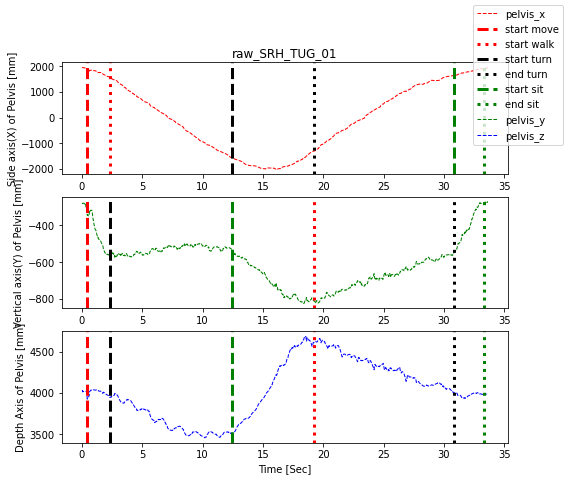

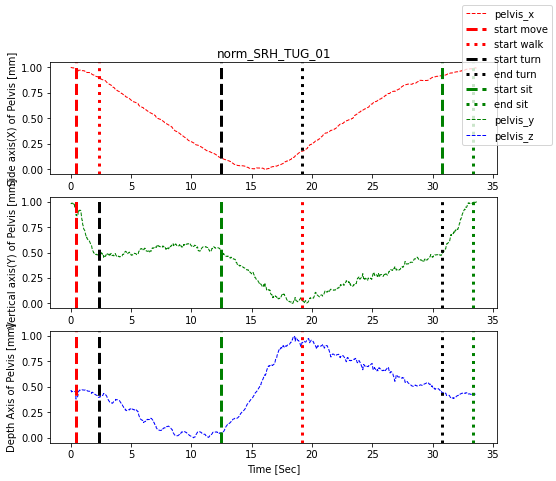

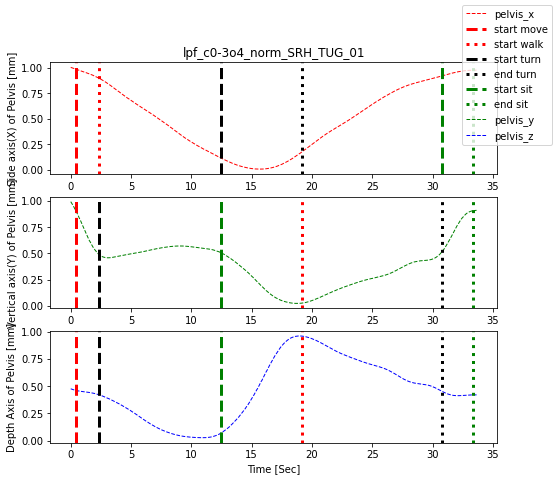

In [3]:
illtyeps = next(os.walk(datasetDir))[1]  # 
save = True
lpf_order = 4
freqs = [0.3] # [0.5, 3.5]

for freq in freqs:
    cutoff_freq = freq 
    
    clear_output(wait=True)
    datasetDir = rootDir + expertFolder + viewFolder

    os.chdir(datasetDir) ; print(" Current workaing path [dataset] ", os.getcwd())  # -- Dataset 있는 곳으로 경로 변경 
    utils = preprocess(datasetDir, expertFolder)
    plot = plotGragh(actSplit=True, save=True)

    for selected_type in illtyeps:
        selected_subjects = next(os.walk(os.path.join(datasetDir,selected_type )))[1]
        numOfsubjects = len( selected_subjects )
        print(" selected Group: {0} \t, # of Subjects: {1} \n --> subject list: {2}".format( selected_type, numOfsubjects, selected_subjects))
        total_Trials = preprocess_forSaving(selected_type = selected_type, save = save)